In [92]:
import numpy as np
from tenpy.linalg import np_conserved
from matplotlib import cm
import os
import matplotlib.pyplot as plt
from BC_observables_functions import *
from matplotlib import rc
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns

In [81]:
fs = 25
plt.rcParams['text.usetex'] = True
plt.rc('xtick',labelsize=fs)
plt.rc('ytick',labelsize=fs)
cmap_s = sns.diverging_palette(h_neg=34, h_pos=198, s=91, l=60, sep=10, n=16, center='light', as_cmap=True)
cmap_b = sns.cubehelix_palette(n_colors=13, start=0.7, rot=0.1, gamma=1.2, hue=0.7, light=0.9, dark=0.3, as_cmap=True)
cmap_f = sns.cubehelix_palette(rot=-.2,as_cmap=True)
evenly_spaced_interval = np.linspace(0, 1, 10)
colors_s = [cmap_s(x) for x in evenly_spaced_interval]
colors_b = [cmap_b(x) for x in evenly_spaced_interval]
colors_f = [cmap_f(x) for x in evenly_spaced_interval]
# Cmap references: https://matplotlib.org/stable/gallery/color/colormap_reference.html

'staggered'             -> alternation of positive and negative links

'walls_opposite'        -> opposite "walls" of positive and negative links

'walls_equal'           -> equal "walls" of positive and negative links

'all_edges_equal'       -> same pattern (alternate + and -) for all the edges of the lattices


In [82]:
# PARAMS

# Directory for the files
main_directory="BSC runs"
if not os.path.exists(main_directory):
	os.makedirs(main_directory)

Lx = 5
Ly = 5
bc_label='walls_opposite'
lambda_values=np.linspace(-1.0,1.0,num=20)
params = dict(t=0, g=np.sqrt(0.5), lam_penalty=40.0, lam_RK=2.5,bc_gaugefield=bc_label)   # g^2=0.5; g^2=1.5
filling = 0.5
chi_max = 500
n_max = 1
S = 0.5
bc_MPS = 'finite'
conserve='N'

# LOAD psi
#string_directory=main_directory+'/L{}/LM{}/'.format(Lx,params['lam_RK'])
#psi = np.load(string_directory+bc_label+'%.2fchi_psi_g_%.2f_t_%.2f_penalty_%.2f_RKterm_%.2f_L_%.0f_S_%.1f.npy' %(chi_max,params['g'], params['t'], params['lam_penalty'], params['lam_RK'], Lx*Ly, S), allow_pickle=True)[0]
psi = np.load('DATA_PLOT_PSI_301123/'+bc_label+'_50_psi_g_%.2f_t_%.2f_penalty_%.2f_RKterm_%.2f_L_%.0f_S_%.1f.npy' %(params['g'], params['t'], params['lam_penalty'], params['lam_RK'], Lx*Ly, S), allow_pickle=True)[0]

In [84]:
# Get expectation values (without matter fields)
gf_x = psi.expectation_value('sigmaz', range(Lx*Ly*2)[::2]).reshape(Lx, Ly)
gf_y = psi.expectation_value('sigmaz', range(Lx*Ly*2)[1::2]).reshape(Lx, Ly)
#Nexp = psi.expectation_value('N', range(Lx*Ly*3)[::3]).reshape(Lx, Ly) - when adding matter fields
Nexp = np.ones(Lx*Ly) #for now

'''
Structure of the Gauss law at vertex (signs):

        |
      2 |
        |
1  ----------- 3
        |
     4  |
        |

G = E1+E4-E2-E3
'''

# Check Gauss law 
gauss_law_exp=np.zeros(Lx*Ly).reshape(Lx,Ly)

#Bulk
for x in range(1,Lx-1):
    for y in range(1,Ly-1):
        gauss_law_exp[x][y]=gf_x[x-1][y]+gf_y[x][y-1]-gf_y[x][y]-gf_x[x][y]

#Vertices
gauss_law_exp[0][0]=-gf_x[0][0]-gf_y[0][0]
gauss_law_exp[Lx-1][0]=gf_x[Lx-2][0]-gf_y[Lx-1][0]
gauss_law_exp[0][Ly-1]=-gf_x[0][Ly-1]+gf_y[0][Ly-2]
gauss_law_exp[Lx-1][Ly-1]=gf_x[Lx-2][Ly-1]+gf_y[Lx-1][Ly-2]

#Boundaries (enforce correctly the boundary conditions!)
bc_x, bc_y=fix_boundary_links(bc_label,Lx,Ly)

print(bc_x,bc_y)

for x in range(1,Lx-1):
    # Bottom boundary
    gauss_law_exp[x][0]=gf_x[x-1][0]+bc_x[x]-gf_x[x][0]-gf_y[x][0]
    # Top boundary
    gauss_law_exp[x][Ly-1]=gf_x[x-1][Ly-1]+gf_y[x][Ly-2]-gf_x[x][Ly-1]-bc_x[x+Lx]
    
for y in range(1,Ly-1):
    
    #Leftmost boundary
    gauss_law_exp[0][y]=bc_y[y]+gf_y[0][y-1]-gf_x[0][y]-gf_y[0][y]
    #Rightmost boundary
    gauss_law_exp[Lx-1][y]=gf_x[Lx-2][y]+gf_y[Lx-1][y-1]-bc_y[y+Ly]-gf_y[Lx-1][y]

    
#print(gf_x)
#print(gf_y)
        
print(gauss_law_exp)

# Flippability array
flipp_exp=np.zeros((Lx-1)*(Ly-1)).reshape((Lx-1),(Ly-1))

print(flipp_exp)

for x in range(Lx-1):
    for y in range(Ly-1):
        # Convert MPS indices to lattice indices
        flipp_exp[x][y]=psi.expectation_value_term([('Pplus', lat2snake_indices(x,y,0,Lx)),('Pplus', lat2snake_indices(x+1,y,1,Lx)),('Pminus', lat2snake_indices(x,y+1,0,Lx)),('Pminus', lat2snake_indices(x,y,1,Lx))])
        flipp_exp[x][y]=flipp_exp[x][y]+psi.expectation_value_term([('Pplus', lat2snake_indices(x,y,1,Lx)),('Pplus', lat2snake_indices(x,y+1,0,Lx)),('Pminus', lat2snake_indices(x+1,y,1,Lx)),('Pminus', lat2snake_indices(x,y,0,Lx))])
        flipp_exp[x][y]=0.5*flipp_exp[x][y]

print(flipp_exp)

[ 0.  -0.5 -0.5 -0.5  0.   0.   0.5  0.5  0.5  0. ] [ 0.   0.5  0.5  0.5  0.   0.  -0.5 -0.5 -0.5  0. ]
[[ 2.77555756e-17 -5.55111512e-17  3.33066907e-16  0.00000000e+00
  -1.11022302e-16]
 [-2.77555756e-16  2.22044605e-16 -3.88578059e-16  3.33066907e-16
  -5.55111512e-17]
 [ 0.00000000e+00  2.22044605e-16  4.80171458e-15  6.10622664e-16
   0.00000000e+00]
 [ 1.11022302e-16  5.55111512e-16 -5.77315973e-15  8.18789481e-16
  -1.11022302e-16]
 [-1.66533454e-16 -3.33066907e-16  1.11022302e-16 -3.05311332e-16
  -4.44089210e-16]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[4.47922070e-01 6.83139772e-02 1.46470238e-04 1.93278026e-07]
 [6.83139772e-02 4.43486558e-01 1.41252223e-02 1.46470237e-04]
 [1.46470238e-04 1.41252223e-02 4.43486558e-01 6.83139772e-02]
 [1.93278045e-07 1.46470237e-04 6.83139772e-02 4.47922070e-01]]


In [85]:
# PLOT STRUCTURE (BULK)
norm = plt.Normalize(-0.5, 0.5)
vmin=-1
vmax=1

flipp_min=0
flipp_max=1

points_x = np.repeat(range(Lx), Ly)
points_y = np.tile(range(Ly), Lx)

central_points_x = np.repeat(range(Lx-1), Ly-1)+0.5
central_points_y = np.tile(range(Ly-1), Lx-1)+0.5

segments_x = segments_y = []
for x in range(Lx-1):
    for y in range(Ly):
        segments_x = np.append(segments_x, np.array([[x, y],[x+1, y]]))
for x in range(Lx):    
    for y in range(Ly-1):
        segments_y = np.append(segments_y, np.array([[x, y],[x, y+1]]))

segments_x = segments_x.reshape(-1, 2, 2)
segments_y = segments_y.reshape(-1, 2, 2)

# PLOT STRUCTURE (BOUNDARY LINKS)
bc_points_x=np.concatenate((np.repeat(0,Ly-2),np.repeat(range(1,Lx-1),2),np.repeat(Lx-1,Ly-2)))
bc_points_y=np.concatenate((np.tile(range(1,Ly-1),1),np.tile(np.array([0,Ly-1]),Lx-2),np.tile(range(1,Ly-1),1)))

segments_bc_x = segments_bc_y = []

for x in [0,Lx-1]:
    for y in range(1,Ly-1):
        if x==0:
            segments_bc_x = np.append(segments_bc_x, np.array([[x-1, y],[x, y]]))
        if x==Lx-1:
            segments_bc_x = np.append(segments_bc_x, np.array([[x, y],[x+1, y]]))

for y in [0,Ly-1]:
    for x in range(1,Lx-1):
        if y==0:
            segments_bc_y = np.append(segments_bc_y, np.array([[x, y-1],[x, y]]))
        if y==Ly-1:
            segments_bc_y = np.append(segments_bc_y, np.array([[x, y],[x, y+1]]))
            
segments_bc_x = segments_bc_x.reshape(-1,2,2)
segments_bc_y = segments_bc_y.reshape(-1,2,2)

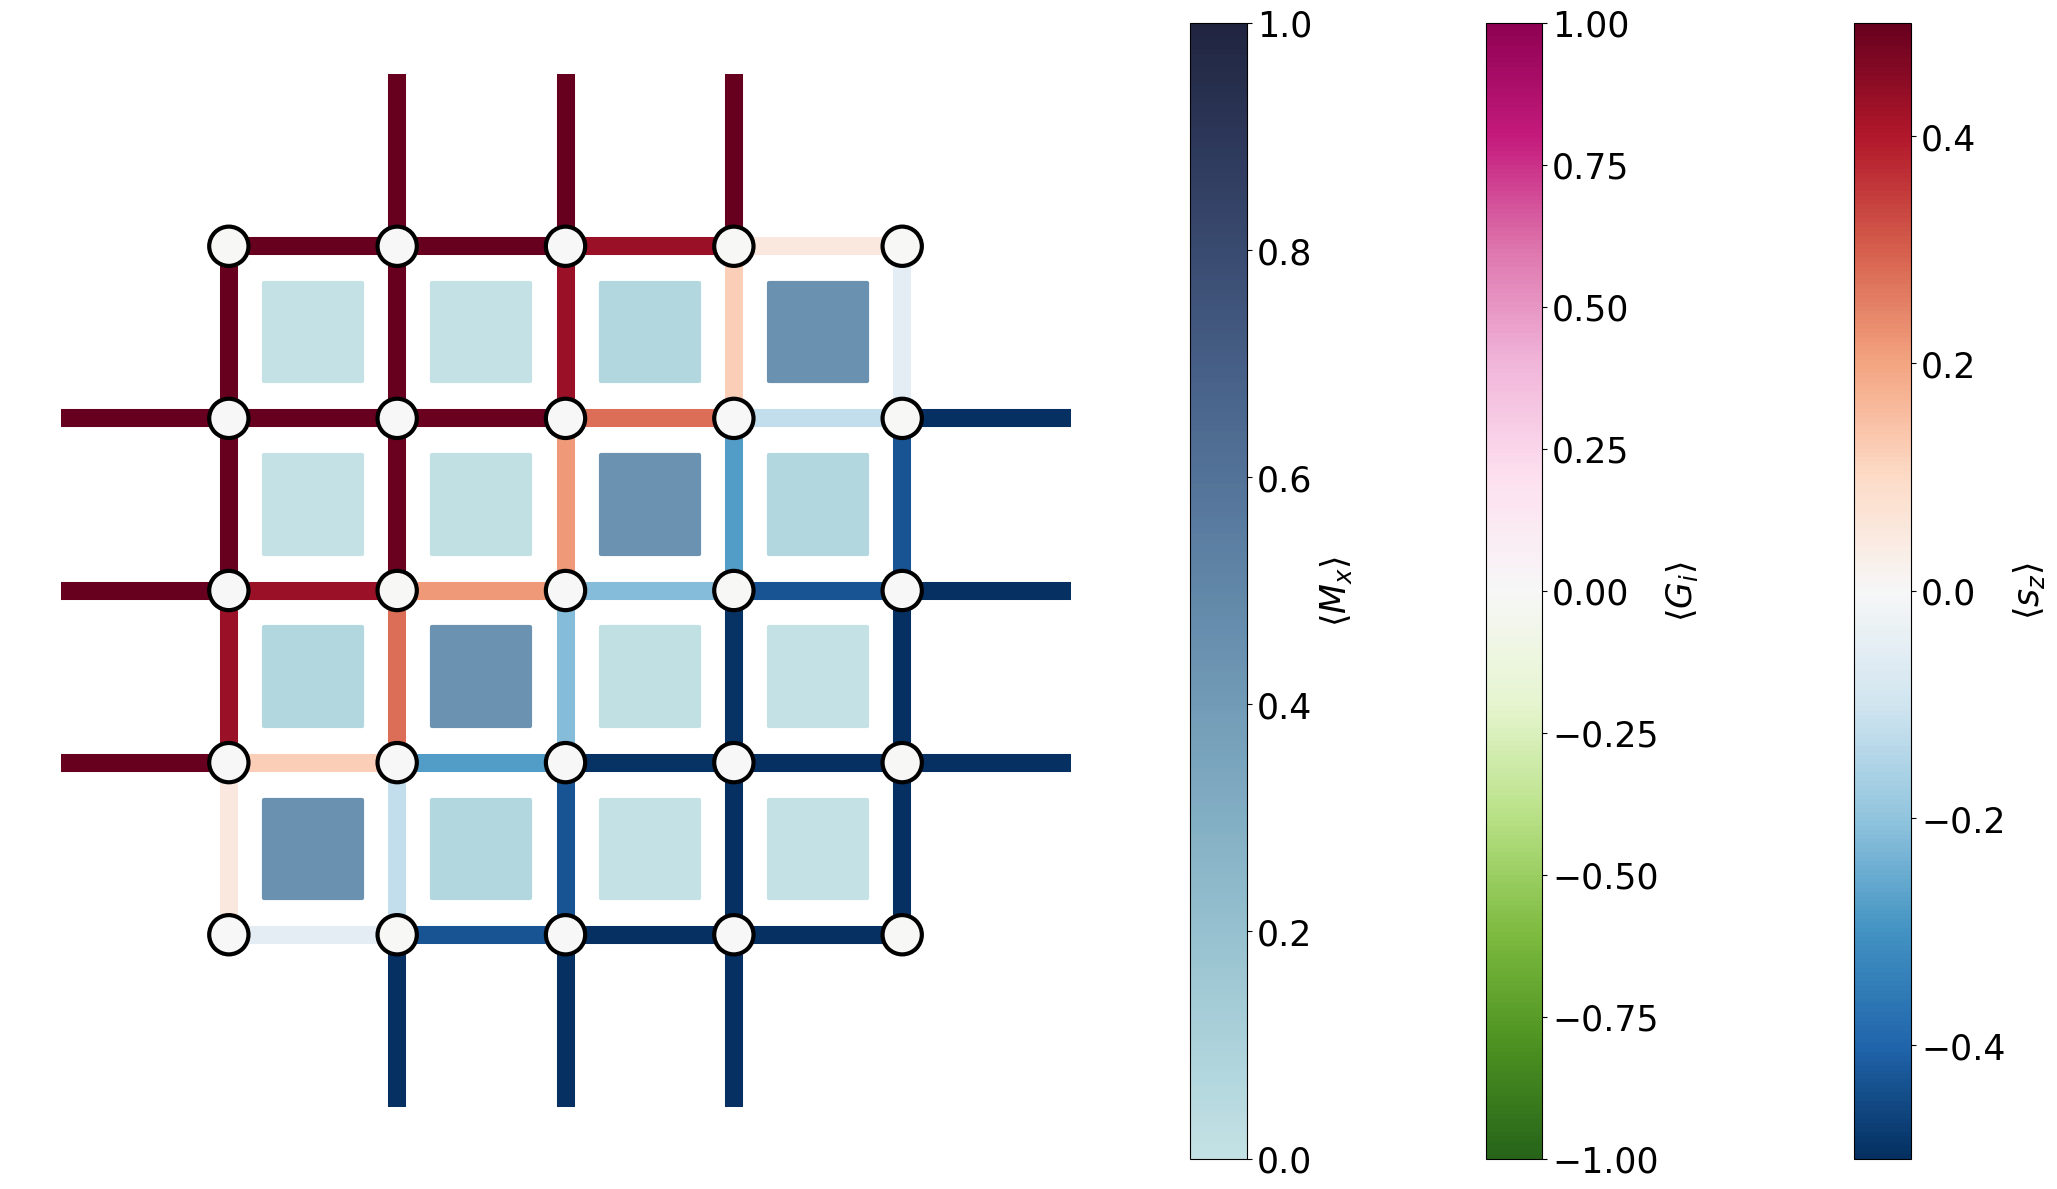

In [91]:
# FIGURE
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(22,12))
ax.set_yticks([])
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

#BONDS (BULK)
lc = LineCollection(segments_x, cmap='RdBu_r', norm=norm)
lc.set_array(gf_x.flatten())
lc.set_linewidth(13)
line = ax.add_collection(lc)

lc = LineCollection(segments_y, cmap='RdBu_r', norm=norm)
lc.set_array(np.delete(gf_y,-1,1).flatten())
lc.set_linewidth(13)
line = ax.add_collection(lc)

#BONDS (BOUNDARY LINKS)
# Set array for boundary conditions: kill zeros 
bc_x_plot=np.asarray(bc_x)
bc_x_plot=np.delete(bc_x_plot,[0,Lx-1,Lx,2*Lx-1])

bc_y_plot=np.asarray(bc_y)
bc_y_plot=np.delete(bc_y_plot,[0,Ly-1,Ly,2*Ly-1])

lc_bc = LineCollection(segments_bc_x, cmap='RdBu_r', norm=norm)
lc_bc.set_array(bc_y_plot)
lc_bc.set_linewidth(13)
line_bc = ax.add_collection(lc_bc)

lc_bc = LineCollection(segments_bc_y, cmap='RdBu_r', norm=norm)
lc_bc.set_array(bc_x_plot)
lc_bc.set_linewidth(13)
line_bc = ax.add_collection(lc_bc)

# Electric field
cbar = plt.colorbar(line, aspect=20)
cbar.ax.tick_params(labelsize=fs)
#cbar.ax.set_ylabel(r'$\langle b_i^\dagger b_{i+1} + h.c \rangle$', fontsize=fs, labelpad=-15, y=1.2, x=-20, rotation=0)
cbar.ax.set_ylabel(r'$\langle s_z \rangle$', fontsize=fs)

# DENSITY PROFILES
# Gauss law
plt.rcParams.update(plt.rcParamsDefault)
sc = ax.scatter(points_x,points_y, s=800, edgecolor='black', linewidth=3, c = gauss_law_exp, cmap='PiYG_r', vmin=vmin, vmax=vmax, zorder=3)
#sc_center = ax.scatter(central_points_x, central_points_y, marker='s',s=800, edgecolor='black', linewidth=3)
cbar = plt.colorbar(sc, aspect=20)
cbar.ax.tick_params(labelsize=fs)
#cbar.ax.set_ylabel(r'$\langle G_i \rangle$', fontsize=fs, labelpad=-15, y=1.2, x=2.5, rotation=0)
cbar.ax.set_ylabel(r'$\langle G_i \rangle$', fontsize=fs)

# Flippability
sc_center = ax.scatter(central_points_x, central_points_y, marker='s',s=5000, edgecolor=None, linewidth=3,c = flipp_exp, cmap=cmap_f, vmin=flipp_min, vmax=flipp_max, zorder=3)
cbar = plt.colorbar(sc_center, aspect=20)
cbar.ax.tick_params(labelsize=fs)
cbar.ax.set_ylabel(r'$\langle M_x \rangle$', fontsize=fs)

plt.tight_layout()
plt.show()
#plt.savefig('FULL_PROVA_0812_'+bc_label+'_{}g_{}Lx_{}Ly_{}S_{}penalty_{}RK.pdf'.format(params['g'],Lx,Ly,S,params['lam_penalty'],params['lam_RK']),bbox_inches='tight')